In [1]:
from datetime import date, datetime

import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier, LGBMRegressor
from matplotlib import pyplot as plt
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)
from pandas_profiling import ProfileReport
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder

sns.set()


pd.options.display.max_rows = 40
pd.options.display.max_columns = None

# I. Javier Mermet

![](https://metadata.fundacionsadosky.org.ar/media/media/images/HOPP_-_Flyer_web_metadata.png)

En este notebook expongo mi resolución a la competencia `Series de tiempo en Hopp`, patrocinada por [Alix Partners](https://www.alixpartners.com) en el contexto de la [edición 35 de la ECI](https://eci.dc.uba.ar).

La competencia nos invita a predecir pagos de prestamos otorgados por _HOPP_. Tenemos data histórica de pagos y metadata de los préstamos otorgados. Para cada préstamo podemos tener varias fechas de pagos, lo cual le da una estructura de series de tiempo.

Trabajar con series de tiempo presenta algunas complejidades adicionales respecto a problemas tabulares, dado que tenemos grupos no independientes de datos con una secuencia temporal que no puede ser ignorada. La propuesta es:

- Analizar la data de un modo sencillo y hacer doble click donde fuera necesario
  - Al enfrentarse con un dominio desconocido, es útil tener todo el contexto. Sin embargo, algunos cruces avanzados se deben elaborar a fin de validar y testear hipotesis que puedan ayudar en el modelado.
- Utilizar un modelo lo más sencillo posible de entrenar.
  - Idealmente, un modelo que podamos explicar, ya sea desde su estructura o valores SHAP. Si bien esto no es pedido, es una práctica a la cual cada día se le presta más atención. En particular en ambientes de fintech, donde los estudios sobre fairness han cobrado mucha relevancia.
- Asegurarse de no utilizar features que filtren información.
  - Uno podría, por ejemplo, agregar como feature el promedio histórico de pagos. Sin embargo, esto podría estar filtrando información de pagos futuros a los pagos iniciales.
- Validar localmente mejoras en los modelos
  - Antes de hacer submits, idealmente quisiera poder comparar modelos localmente.
  - Más allá del contexto de la competencia, mi intención es seguir las mejores prácticas que me sean conocidas del área. De este modo, puedo entregar un pipeline robusto, extensible y claro.
- Aprender, divertirse, conocer
  - Este tipo de iniciativas son ideales para aprender nuevas herramientas, tecnologías o metodologías que quizás uno no pueda aplicar en el día a día. El leaderboard es una ruleta, pero aprender tiene cero riesgo.
  - Lo anterior no tiene sentido si genera estrés. Es una oportunidad donde no hay costos en entregar tarde o algo no tan performante. El camino debe ser disfrutable.
  - La competencia se acompaña de un slack donde los/las/les participantes se pueden sumar e intercambiar ideas. Es ideal el entorno para conocer más gente del ámbito y aprender juntos.
  
Durante este notebook, describiré mis ideas y observaciones, pero hablando en plural: es una invitación a quien lo lee de acompañarme en mi proceso mental. Dicho todo esto, veamos como llegamos a un resultado.

# Cargar y analizar datos

La etapa de `EDA` (Análisis exploratorio de datos) es la primer tarea a encarar en cualquier problema de Data Science/Machine learning. Como dije antes, mas cuando se desconoce el dominio.

Tenemos la ventaja de tener un muy comprensivo glosario de datos y acceso a representantes de HOPP que nos pueden aclarar dudas sobre los datos.

Considero que hacer un comprensivo análisis manual de cada variable en cada dataset haría este notebook mucho mas largo de lo que es y mucho mas dificil de seguir. Por tanto, voy a usar `pandas_profiling` para obtener un primer vistazo a los datos y luego manualmente analizar los cruces que sean necesarios para validar hipótesis o dudas de seguimiento de lo que veamos ahí.

Para cada dataset provisto agrego una seccion con el glosario de datos para mi propia referencia.

In [83]:
GDRIVE_URI = "https://drive.google.com/uc?id={gid}&export=download&confirm=t".format

## Agency product name
>  Información sobre agencia que agrupa créditos, el tipo de crédito (PDL o BGL, payday loans o business growth loans, respectivamente).

```
AgencyId (Entero): ID de agencia (dependencia) de Hopp a la que pertenece el crédito.

ProductName (Categórica): Tipo de producto (PDL, BGL).

Country (Categórica): País de la operación.
```

In [84]:
df_agency = pd.read_csv(GDRIVE_URI(gid="1bQvEugQDh3B0bEepbGdJkfFwztW2XeX7"))
profile = ProfileReport(df_agency, title="Agency product name", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

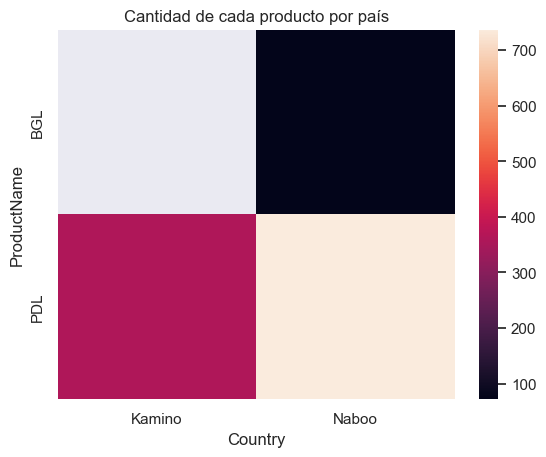

In [3]:
plt.title("Cantidad de cada producto por país")
sns.heatmap(
    df_agency.pivot_table(
        index="ProductName", columns="Country", values="AgencyId", aggfunc="count"
    )
)
plt.show()

Es muy notable que el producto `BGL` no está disponible en `Kamino`. 

## Funding Origination

> Información sobre a qué agencia pertenece cada crédito y la fecha de creación de cada crédito.

```
- LoanId (Entero): ID único del crédito.

- AgencyId (Entero): ID de agencia (dependencia) de Hopp a la que pertenece el crédito.

- FundingID (Entero): ID de la entidad financiadora.

- OriginationDate (Datetime): Fecha de originación del crédito.

- InstallmentAmount (Decimal): Valor del préstamo (valor de la cuota correspondiente = InstallmentAmount/Term).

- Periodicity (Categórica): Periodicidad del crédito.

- LoanOperationalStatus (Categórica): Estado operacional del crédito al fin del período (diciembre 2020).

- VAT (Entero): Porcentaje asignado al IVA.

- Term (Entero): Cantidad de plazos del crédito.
```

In [85]:
df_orig = pd.read_csv(
    GDRIVE_URI(gid="1YYs_QLCruTAxtM86ZNMQb7fwuTj2OmYw"), parse_dates=["OriginationDate"]
)
df_orig.rename(inplace=True, columns={"InstallmentAmount": "LoanAmount"})
df_orig["InstallmentAmount"] = df_orig.LoanAmount / df_orig.Term

profile = ProfileReport(df_orig, title="Funding Origination", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Podemos ver un primer vistazo a las fechas de origen y la distribución de los montos de los préstamos. Esta tiene una cola larga de pocos prestamos por montos grandes.

En base a lo dicho en el glosario de datos, se entiende que la columna originalmente nombrada `InstallmentAmount` en realidad es el monto total del préstamo. Por ello se agrega una nueva columna con el monto de cada cuota.

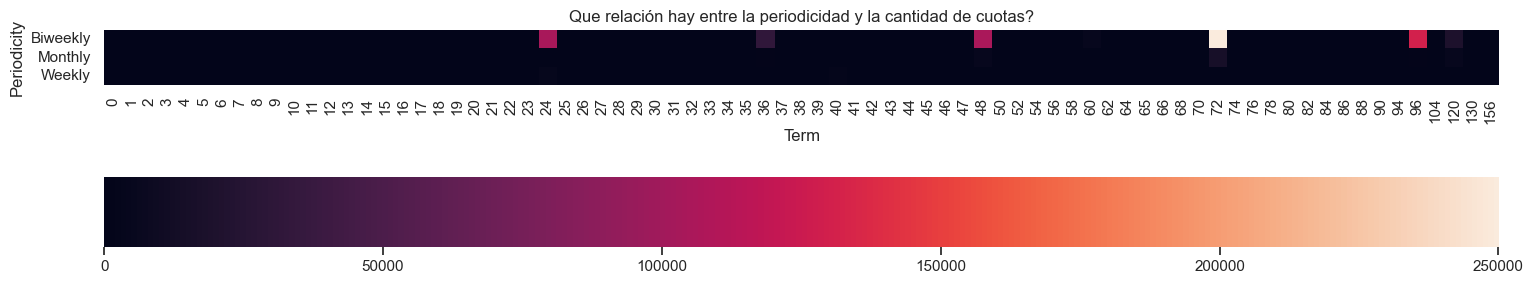

In [5]:
plt.figure(figsize=(18, 8))
plt.title("Que relación hay entre la periodicidad y la cantidad de cuotas?")
sns.heatmap(
    df_orig.pivot_table(
        index="Periodicity",
        columns="Term",
        values="LoanId",
        aggfunc="count",
        fill_value=0,
    ),
    square=True,
    cbar_kws={"orientation": "horizontal"},
)
plt.show()

Podemos notar que hay prestamos con pagos bisemanales con una variedad de cantidad de cuotas, siempre multiplo de 12.

## Payments
> Incluye pagos y dinámica histórica (desde 2019) de las operaciones de Hopp. La creación de créditos fue removida desde 2019 en adelante. Datos hasta junio 2020 inclusive.

```
LoanId (Entero): ID único del crédito.

PaymentId (Entero): ID único de cada pago.

PaymentSource (Categórica): Fuente de Pago (regular, contractor, alternative, additional).

PaymentType (Entero): Variable que clasifica distintos mecanismos de pago adicional.

PaymentTypeDescription (Categórica): Descripción de los mecanismos de pago adicional.

PaymentAmount (Decimal): Total pagado en el pago con PaymentId de la fila.

PaymentPrincipalAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de principal.

PaymentInterestAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de interés.

PaymentVATAmount (Decimal): Parte del pago con PaymentId de la fila aplicado al saldo de IVA.

PaymentDueDate (Datetime): Fecha de aplicación del pago procesado (no disponible para todas las PaymentSources).

PaymentTransferDate (Datetime): Fecha en que Hopp recibió la transferencia bancaria del pago indicado (no disponible para todas las PaymentSources).

PaymentProcessingDate (Datetime): Fecha en que Hopp procesó el pago indicado (disponible para todas las PaymentSources).
```

In [86]:
df_payments = pd.read_csv(
    GDRIVE_URI(gid="1qdfApOnVp2Gq2PMHlUrT8rIBx6IVUDYj"),
    parse_dates=["PaymentProcessingDate", "PaymentTransferDate", "PaymentDueDate"],
)

profile = ProfileReport(df_payments, title="Payments", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
(
    df_payments.groupby(
        ["LoanId", "PaymentProcessingDate", "PaymentSource", "PaymentType"],
        dropna=False,
    ).PaymentId.nunique()
    == 1
).mean()

0.8136082524215869

Algo que noté, es que para un mismo préstamo, fecha de procesamiento, `PaymentSource` y `PaymentType`, hay un 18% de combinaciones que tienen mas de un pago registrado. Esto puede ser un problema, veamos la distribución de la varianza de los grupos.

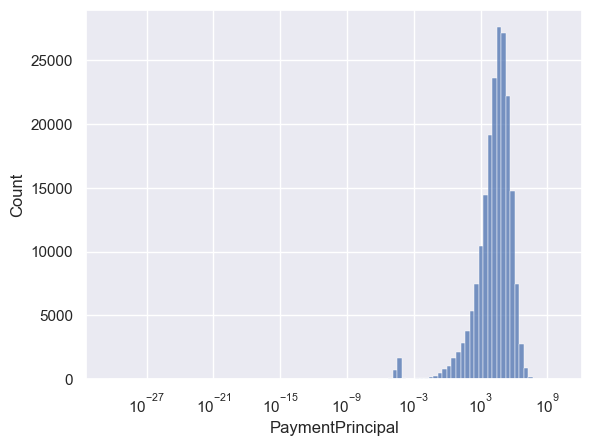

In [8]:
sns.histplot(
    (
        df_payments.groupby(
            ["LoanId", "PaymentProcessingDate", "PaymentSource", "PaymentType"],
            dropna=False,
        ).PaymentPrincipal.var()
    )
    .replace(0, None)
    .dropna(),
    bins=100,
    log_scale=True,
)
plt.show()

Vemos que no es despreciable la varianza intra grupos, por tanto, tomo la hipótesis (validada empiricamente entre distintas variantes de feature engineering hechas) de que para que el modelo distinga mejor la señal del ruido y pueda hacer predicciones más adecuadas, puedo agrupar los pagos y sumar los montos.

In [9]:
df_payments = (
    df_payments.groupby(
        ["LoanId", "PaymentProcessingDate", "PaymentSource", "PaymentType"],
        dropna=False,
    )
    .agg(
        {
            "PaymentTypeDescription": pd.Series.mode,
            "PaymentAmount": "sum",
            "PaymentPrincipal": "sum",
            "PaymentInterest": "sum",
            "PaymentVAT": "sum",
            "PaymentDueDate": "min",
            "PaymentTransferDate": "min",
        }
    )
    .reset_index()
    .sort_values(["PaymentProcessingDate", "LoanId"])
)

Esta ultima transformación lleva bastante tiempo, pero reduce la huella de memoria y mejora notablemente la performance de los modelos.

<AxesSubplot:xlabel='PaymentSource', ylabel='PaymentPrincipal'>

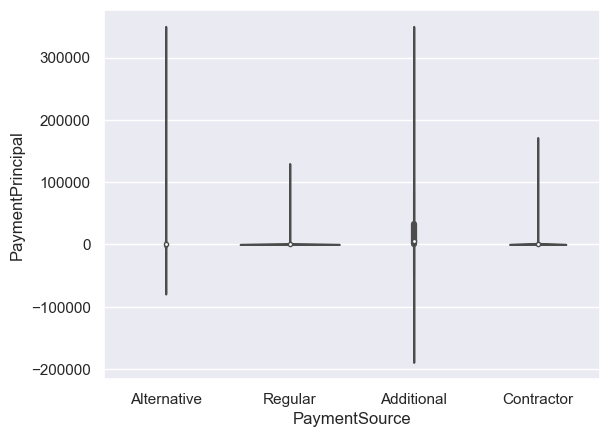

In [10]:
sns.violinplot(
    data=df_payments, y="PaymentPrincipal", x="PaymentSource", cut=0, showfliers=False
)

Las distribuciones de `PaymentPrincipal` por `PaymentSource` son muy distintas. En el anterior gráfico no llegamos a apreciarlo por los valores extremos. Veamos los promedios.

In [11]:
df_payments.groupby(
    ["PaymentSource", "PaymentType"], dropna=False
).PaymentPrincipal.mean()

PaymentSource  PaymentType
Additional     4.0            53539.955808
               8.0            10692.632503
               13.0               0.000000
Alternative    NaN             2351.979827
Contractor     NaN              373.392112
Regular        NaN              339.263914
Name: PaymentPrincipal, dtype: float64

Esto resulta **muy** importante: si elegimos usar un solo modelo, tenemos que ser muy cuidadosos con como interpreta esta variable y como codifica esta información. De otro modo, estará tratando de generalizar entre cohortes con promedios con diferencias de hasta **2** ordenes de magnitud.

Este insight resultó un pivote en el enfoque de desarrollo: en lugar de tener un modelo general, terminé optando por un modelo por `PaymentSource`.

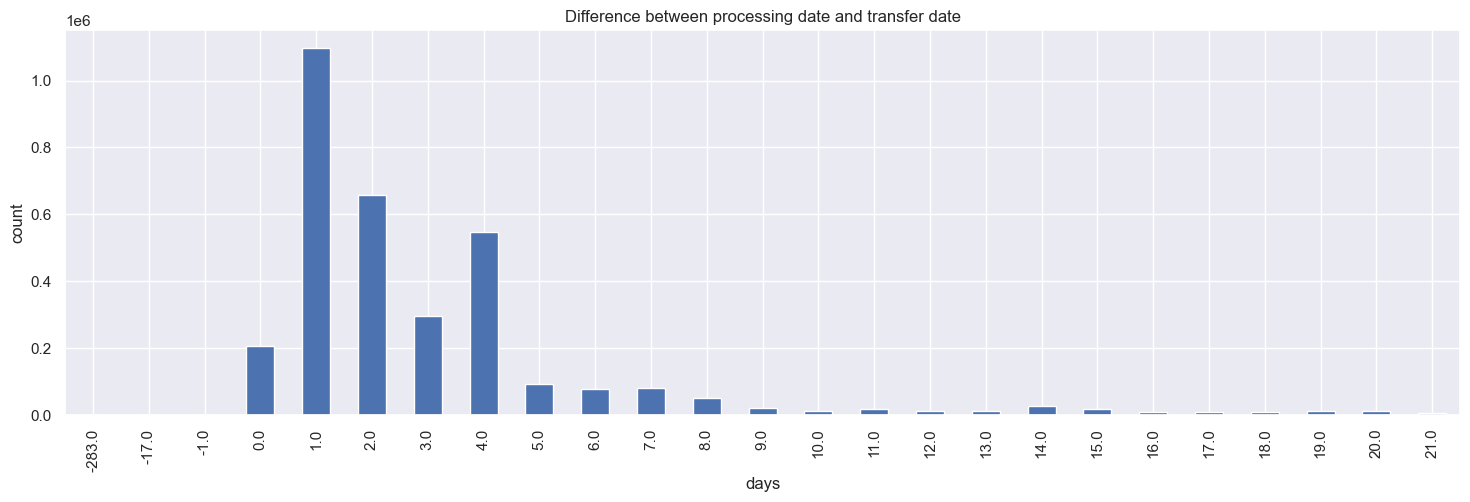

In [12]:
(
    df_payments.PaymentProcessingDate - df_payments.PaymentTransferDate
).dt.days.value_counts().sort_index().head(25).plot(
    kind="bar",
    title="Difference between processing date and transfer date",
    figsize=(18, 5),
    xlabel="days",
    ylabel="count",
)
plt.show()

La mayor parte de las transferencias se procesan en el plazo de una semana. Hay algunos casos claramente erroneos en el dataset, donde la diferencia es negativa. No es particularmente util para modelar, dado que no conocemos las fechas de transferencia en los pagos a predecir. Podríamos inputarlos, pero agrega una gran capa de complejidad al modelo.

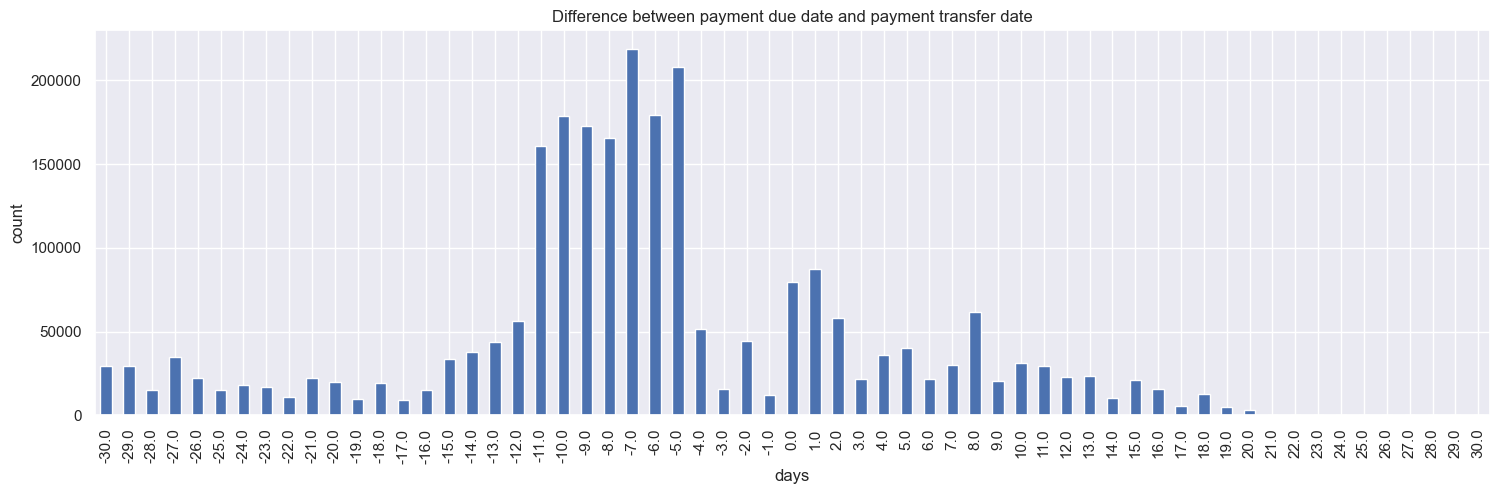

In [13]:
x = (
    df_payments[df_payments.PaymentDueDate.notna()].PaymentDueDate
    - df_payments[df_payments.PaymentDueDate.notna()].PaymentTransferDate
).dt.days
x = x[x.between(-30, 30)].value_counts().sort_index()
x.plot(
    kind="bar",
    title="Difference between payment due date and payment transfer date",
    figsize=(18, 5),
    xlabel="days",
    ylabel="count",
)
plt.show()

Al igual que en el gráfico anterior, no nos sirve para predecir, pero si para entender el negocio/dominio. Pero si se nota una tendencia a pagar fuera de fecha. Esto puede ser util para trazar un perfil historico de cada prestamo.

In [14]:
df_payments["DiffProcessingDateDueDate"] = (
    df_payments["PaymentProcessingDate"] - df_payments["PaymentDueDate"]
).dt.days

In [15]:
mean_diffdates = (
    df_payments[df_payments.PaymentSource == "Regular"]
    .sort_values("PaymentProcessingDate")
    .groupby("LoanId")
    .DiffProcessingDateDueDate.apply(np.diff)
    .apply(np.mean)
)

/home/nox/repos/venv/lib64/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


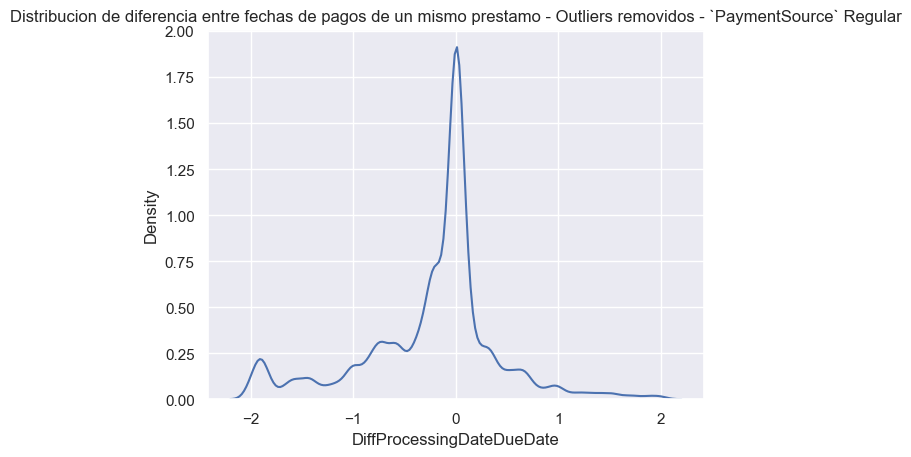

In [16]:
sns.kdeplot(mean_diffdates[mean_diffdates.between(-2, 2)])
plt.title(
    "Distribucion de diferencia entre fechas de pagos de un mismo prestamo - Outliers removidos - `PaymentSource` Regular"
)
plt.show()

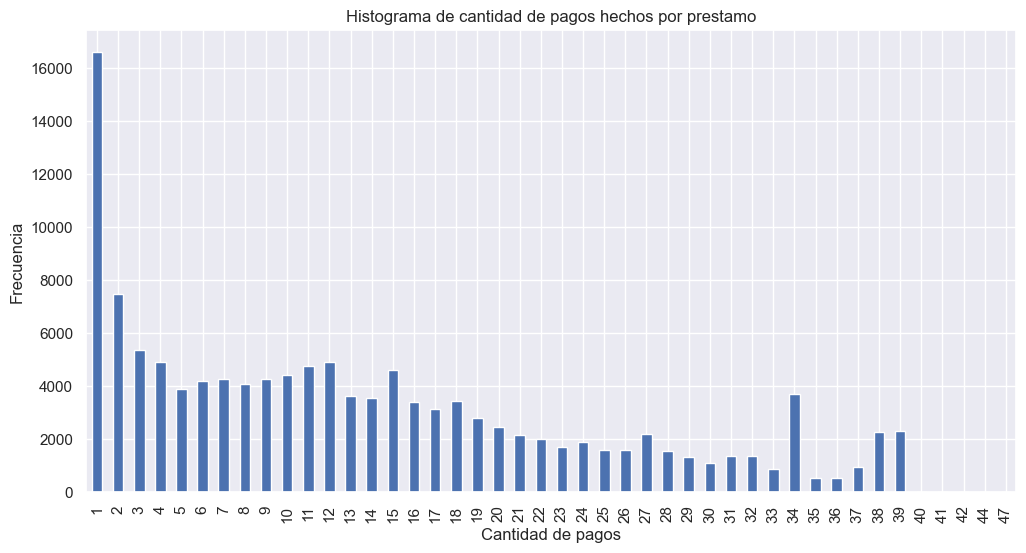

In [17]:
plt.figure(figsize=(12, 6))
ax = (
    df_payments[df_payments.PaymentPrincipal > 0]
    .LoanId.value_counts()
    .value_counts()
    .sort_index()
    .plot(kind="bar")
)
ax.set_ylabel("Frecuencia")
ax.set_xlabel("Cantidad de pagos")
plt.title("Histograma de cantidad de pagos hechos por prestamo")
plt.show()

Si bien tenemos una inmensa mayoría de prestamos con un solo pago, muchos tienen mucho historial. Claramente, no podemos filtrar los que tienen mas de un pago para armar features laggeadas.

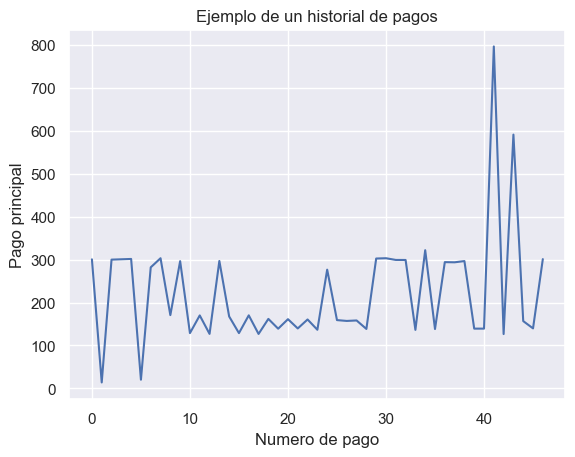

In [18]:
ax = (
    df_payments[(df_payments.LoanId == 9344259)]
    .sort_values("PaymentProcessingDate")
    .PaymentPrincipal.reset_index(drop=True)
    .plot()
)
plt.title("Ejemplo de un historial de pagos")
ax.set_ylabel("Pago principal")
ax.set_xlabel("Numero de pago")
plt.show()

Este ejemplo invalida varias hipotesis previas sobre la tabla de amortizacion (creciente/decreciente lineal/exponencialmente), pero es razonable: dado que no necesariamente pagarán siempre lo mismo

## Indexed dataset
> Información de tipo de indexación de cada crédito en el portafolio.

```
LoanId (Entero): ID único del crédito.

ProductName (Categórica): Tipo de producto (PDL, BGL).

Type (Categórica): Variable que indica si el crédito está indexado (Base, D-Indexed).

D-IndexedTo (Categórica): Variable que indica a quién indexa el crédito (Hopp, Zoltan, Ringu, Freeman).
```

In [87]:
df_dindex = pd.read_csv(GDRIVE_URI(gid="1jonMnGDAzN0LqrLU9_2aVH9LDc0jej0U"))

profile = ProfileReport(df_dindex, title="Indexed to", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Predictions sample
> Template con los préstamos y fechas a predecir.

In [88]:
predictions_sample = pd.read_csv(
    GDRIVE_URI(gid="1vrvlUYT_bLFnb-sC93xo4x6dAKoUCphW"),
    names=["PaymentCode", "PaymentPrincipal"],
    dtype={"PaymentCode": str, "PaymentPrincipal": float},
)

predictions_sample = predictions_sample.join(
    predictions_sample.PaymentCode.astype(str).str.extract(
        r"^(?P<PaymentSource>\d{2})(?P<Date>\d{6})(?P<LoanId>.*)"
    )
)

predictions_sample.LoanId = predictions_sample.LoanId.astype(int)
predictions_sample.PaymentSource = predictions_sample.PaymentSource.astype(int)
# predictions_sample.PaymentTypeId = predictions_sample.PaymentTypeId.astype(int)

predictions_sample.Date = pd.to_datetime(
    predictions_sample.Date, format="%y%m%d"
).dt.date

predictions_sample["PaymentType"] = predictions_sample.PaymentSource.apply(
    lambda x: x if x not in (0, 1, 2) else None
)

predictions_sample.PaymentSource = predictions_sample.PaymentSource.map(
    {0: "Regular", 1: "Alternative", 2: "Contractor"}
).fillna("Additional")

In [21]:
predictions_sample.head()

,PaymentCode,PaymentPrincipal,PaymentSource,Date,LoanId,PaymentType
0,022102049402357,NaN,Contractor,2021-02-04,9402357,NaN
1,00201030668519,NaN,Regular,2020-10-30,668519,NaN
2,002011249339435,NaN,Regular,2020-11-24,9339435,NaN
3,002104209148631,NaN,Regular,2021-04-20,9148631,NaN
4,00210607131505,NaN,Regular,2021-06-07,131505,NaN


In [22]:
orig_loanids = set(df_orig.LoanId.unique())
predictions_loanids = set(predictions_sample.LoanId.unique())
print(
    f"Todos los prestamos a predecir tienen historial? {(orig_loanids & predictions_loanids) == predictions_loanids}. Diff: {len(predictions_loanids - orig_loanids)}"
)

Todos los prestamos a predecir tienen historial? False. Diff: 5


In [23]:
predictions_sample[~predictions_sample.LoanId.isin(df_orig.LoanId)]

,PaymentCode,PaymentPrincipal,PaymentSource,Date,LoanId,PaymentType
7928,002110295405,NaN,Regular,2021-10-29,5405,NaN
50127,002112285406,NaN,Regular,2021-12-28,5406,NaN
944338,002110225404,NaN,Regular,2021-10-22,5404,NaN
1109375,002112305409,NaN,Regular,2021-12-30,5409,NaN
1116352,002107205403,NaN,Regular,2021-07-20,5403,NaN
1220610,002107235403,NaN,Regular,2021-07-23,5403,NaN


In [24]:
# Pasado por slack
cheats = {
    "002107235403": 1474,
    "002107205403": 1474,
    "002110225404": 591,
    "002110295405": 488,
    "002112285406": 1247,
    "002112305409": 1253,
}

In [25]:
loan_ids_to_predict = predictions_sample.LoanId.unique()

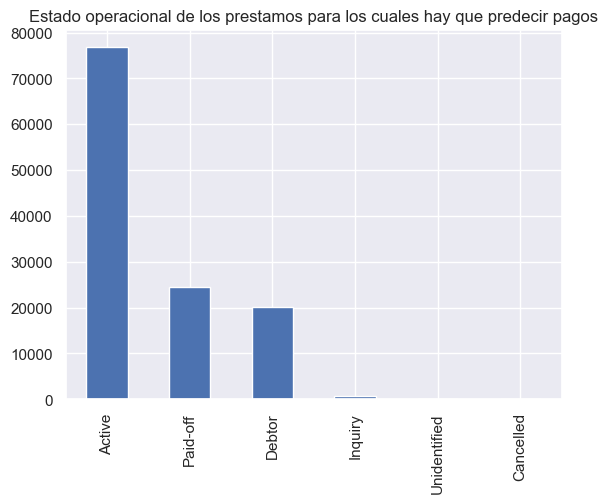

In [26]:
df_orig[
    df_orig.LoanId.isin(loan_ids_to_predict)
].LoanOperationalStatus.value_counts().plot(kind="bar")
plt.title("Estado operacional de los prestamos para los cuales hay que predecir pagos")
plt.show()

In [27]:
predictions_sample.LoanId.value_counts()

653139     64
9361293    64
9275791    59
9343898    59
9359087    59
           ..
9143458     1
9145866     1
519749      1
9279168     1
9153809     1
Name: LoanId, Length: 122351, dtype: int64

Varios insights:
- Muchas columnas de pagos no estan disponibles
- Hay prestamos para los cuales hay que predecir varios pagos

# Cruce de pagos y origenes

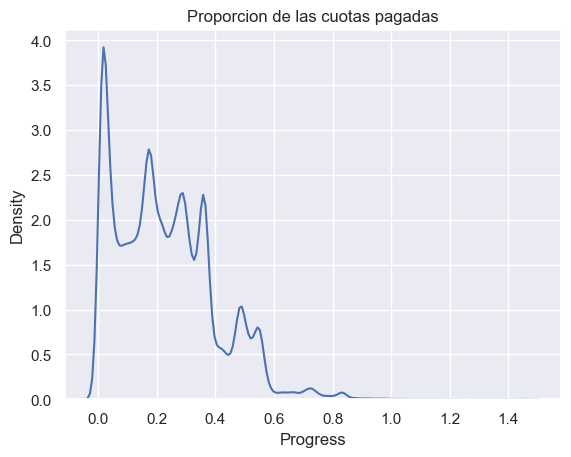

In [28]:
df = df_orig.merge(
    df_payments.LoanId.value_counts().rename("PaymentsRegistered"),
    left_on="LoanId",
    right_index=True,
)
df["Progress"] = df.PaymentsRegistered / df.Term
sns.kdeplot(df[np.isfinite(df.Progress)].Progress)
plt.title("Proporcion de las cuotas pagadas")
plt.show()

# Tenemos que predecir para prestamos... raros?

Algunos prestamos tienen `Term = 0`. Van a ser un problema? Pareciera que la respuesta es `quizas`.

In [29]:
predictions_sample.LoanId.isin(df_orig[df_orig.Term == 0].LoanId).nunique()

2

# Preparar data para entrenamiento

En esta sección se crean varias features. No todas fueron utilizadas en el modelo final, pero se dejan como referencia.

En principio se unen los datasets provistos y se:
- Arman features de historial de retrasos en los pagos
- Agregan features describiendo el historial pasado de pagos
- Agregan features describiendo la proporción del prestamo pagada

Para estas features laggeadas se utilizan `window functions` de pandas, en particular, ventanas expansivas. Se debe hacer con mucho cuidado de:
- Utilizar _solo_ data pasada.
  - Por ello hay algunas operaciones de lagging, dado que la implementacion nativa toma la fila actual tambien
- Cuidar de no repetir datos para el join

In [30]:
df = pd.merge(df_payments, df_orig, left_on="LoanId", right_on="LoanId", how="left")
df = df.merge(df_dindex, left_on="LoanId", right_on="LoanId", how="left")

In [31]:
df["WasOnTime"] = df.PaymentProcessingDate <= df.PaymentDueDate
df["Lateness"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days
df["WasLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 15
df["WasReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 30
df["WasReallyReallyLate"] = (df.PaymentProcessingDate - df.PaymentDueDate).dt.days > 90

df = df.sort_values(
    by=["LoanId", "PaymentSource", "PaymentType", "PaymentProcessingDate"]
).reset_index(drop=True)

In [32]:
print(len(df))

3382183


In [33]:
df["LoanProp"] = df.PaymentPrincipal / df.LoanAmount

x = (
    df.groupby(["LoanId", "PaymentSource", "PaymentType"], dropna=False)
    .expanding()
    .LoanProp.agg(["mean", "min", "max", "median"])
    .reset_index(drop=False, level=["LoanId", "PaymentSource", "PaymentType"])
    .groupby(["LoanId", "PaymentSource", "PaymentType"], dropna=False)
    .shift(1)
    .add_prefix("LoanProp_")
)

df.drop(columns=["LoanProp"], inplace=True)

In [34]:
z = (
    df.groupby(["LoanId", "PaymentSource", "PaymentType"], dropna=False)
    .expanding()
    .PaymentPrincipal.agg(["mean", "min", "max", "median"])
    .reset_index(drop=False, level=["LoanId", "PaymentSource", "PaymentType"])
    .groupby(["LoanId", "PaymentSource", "PaymentType"], dropna=False)
    .shift(1)
    .add_prefix("PaymentPrincipal_")
)

In [35]:
w = (
    df.groupby(["LoanId", "PaymentSource", "PaymentType"], dropna=False)
    .expanding()[
        ["WasOnTime", "Lateness", "WasLate", "WasReallyLate", "WasReallyReallyLate"]
    ]
    .agg("mean")
    .reset_index(drop=False, level=["LoanId", "PaymentSource", "PaymentType"])
    .groupby(["LoanId", "PaymentSource", "PaymentType"], dropna=False)
    .shift(1)
    .add_suffix("_mean")
)

In [36]:
df = df.join(x, how="inner")

In [37]:
df = df.join(z, how="inner")

In [38]:
df = df.join(w, how="inner")

In [39]:
len(df)

3382183

In [40]:
df["IsZero___"] = df.PaymentPrincipal == 0

In [41]:
(df.PaymentPrincipal == 0).mean()

0.4896846208499067

Casi la mitad de las filas tienen un monto principal de cero. No debería ser un problema.

In [42]:
df["WeeksSinceOrigination"] = (
    df.PaymentProcessingDate - df.OriginationDate
).dt.days // 7

In [43]:
df.columns

Index(['LoanId', 'PaymentProcessingDate', 'PaymentSource', 'PaymentType',
       'PaymentTypeDescription', 'PaymentAmount', 'PaymentPrincipal',
       'PaymentInterest', 'PaymentVAT', 'PaymentDueDate',
       'PaymentTransferDate', 'DiffProcessingDateDueDate', 'AgencyId',
       'FundingID', 'OriginationDate', 'LoanAmount', 'Periodicity',
       'LoanOperationalStatus', 'VAT', 'Term', 'InstallmentAmount',
       'ProductName', 'Type', 'D-IndexedTo', 'WasOnTime', 'Lateness',
       'WasLate', 'WasReallyLate', 'WasReallyReallyLate', 'LoanProp_mean',
       'LoanProp_min', 'LoanProp_max', 'LoanProp_median',
       'PaymentPrincipal_mean', 'PaymentPrincipal_min', 'PaymentPrincipal_max',
       'PaymentPrincipal_median', 'WasOnTime_mean', 'Lateness_mean',
       'WasLate_mean', 'WasReallyLate_mean', 'WasReallyReallyLate_mean',
       'IsZero___', 'WeeksSinceOrigination'],
      dtype='object')

In [44]:
categories = [
    "PaymentSource",
    "PaymentType",
    "AgencyId",
    "FundingID",
    "Periodicity",
    "LoanOperationalStatus",
    "VAT",
    "Term",
    "ProductName",
    "Type",
    "D-IndexedTo",
    "LoanId",
]  # "LoanId"]
for category in categories:
    df[category] = df[category].astype("category")

In [45]:
train_columns = [
    #'LoanId',
    "PaymentSource",
    "PaymentType",
    #'DiffProcessingDateDueDate',
    "AgencyId",
    "FundingID",
    "LoanAmount",
    "Periodicity",
    "LoanOperationalStatus",
    "VAT",
    "Term",
    "InstallmentAmount",
    "ProductName",
    "Type",
    "D-IndexedTo",
    #'WasOnTime', 'Lateness', 'WasLate', 'WasReallyLate', 'WasReallyReallyLate',
    "PaymentPrincipal_mean",
    "PaymentPrincipal_min",
    "PaymentPrincipal_max",
    "PaymentPrincipal_median",
    #'LoanProp_mean', 'LoanProp_min', 'LoanProp_max','LoanProp_median',
    #'WasOnTime_mean', 'Lateness_mean', 'WasLate_mean', 'WasReallyLate_mean', 'WasReallyReallyLate_mean',
    #'IsZero___',
    #'MonthsSinceOrigination',
    #'WeeksSinceOrigination'
]

## Armado de datasets

La estrategia será:
- Utilizar los ultimos $p$ pagos de cada prestamo como set de holdout. Esto quiere decir que nuestro dataset de holdout tendrá todos los prestamos para los cuales hay menos de $p+1$ prestamos registrados, pero estos no se verán en entrenamiento. Tendremos más, por supuesto.
- Utilizar el resto como dataset de entrenamiento.
    - Para ello hare cross-validation sobre grupos de prestamos. Entrenaremos con una cierta cantidad de prestamos, y luego predeciremos sobre otros, con una cantidad $k$ de folds.
    - De este modo nos aseguramos estar introduciendo el menor sesgo posible en la elección de los grupos
    
Este esquema nos permite validar localmente antes de hacer un submission, comparando los mejores resultados del cross-validation y revisando si estamos overfitteando con el set de holdout. Este ultimo será nuestra estimacion del error con datos no vistos previamente.

In [46]:
train_df = df[
    (df.PaymentAmount >= 0)
    & (df.LoanAmount > 0)
    & (df.PaymentPrincipal >= 0)
    & (df.PaymentInterest >= 0)
]

In [47]:
total_rows = len(train_df)

holdouts = []
for _ in range(5):
    dups = train_df.duplicated(subset=["LoanId"], keep="last")
    holdouts.append(train_df[~dups])
    train_df = train_df[dups]

holdout_df = pd.concat(holdouts)

assert len(holdout_df) + len(train_df) == total_rows

In [48]:
train_df_additional = train_df[train_df.PaymentSource == "Additional"]
train_df_alternative = train_df[train_df.PaymentSource == "Alternative"]
train_df_contractor = train_df[train_df.PaymentSource == "Contractor"]
train_df = train_df[train_df.PaymentSource == "Regular"]
# train_df = train_df.drop(index=train_df_additional.index)

In [49]:
# loans = train_df.LoanId.value_counts()
# loans = loans[loans > 0]
# len(loans)

In [50]:
# train_df = train_df[train_df.LoanId.isin(loans.index)]

In [51]:
train_df_additional = train_df_additional.sort_values(
    ["LoanId", "PaymentProcessingDate"]
)
train_df_alternative = train_df_alternative.sort_values(
    ["LoanId", "PaymentProcessingDate"]
)
train_df_contractor = train_df_contractor.sort_values(
    ["LoanId", "PaymentProcessingDate"]
)
train_df = train_df.sort_values(["LoanId", "PaymentProcessingDate"])

In [52]:
# train_df.PaymentType = df.PaymentType.astype(str)
# train_df.fillna({"PaymentType":"Nada"}).groupby(["PaymentSource", "PaymentType"], dropna=False).PaymentPrincipal.describe()

In [53]:
# train_df.drop(index=holdout_df.index, inplace=True)

# Entrenamiento - 1 solo  modelo
Inicialmente durante la competencia, había entrenado un solo modelo para todos los `PaymentSource`. Dejo como referencia eso para mayor claridad de por qué lo cambié.

In [54]:
traindf = train_df.copy()

groups = LabelEncoder().fit_transform(traindf.LoanId)

y = traindf.PaymentPrincipal
X = traindf[train_columns]

# TimeSeriesSplit para armar los folds
cv_args = {"test_size": 100, "n_splits": 3}
cv = GroupTimeSeriesSplit(**cv_args)
_ = [_ for _ in cv.split(X, y, groups=groups)]
cv.get_n_splits()

reg = LGBMRegressor()

gscv = GridSearchCV(
    reg,
    param_grid={
        "random_state": [117],
        "boosting_type": ["gbdt"],
        "n_estimators": [100],
        "learning_rate": [0.05, 0.1],
        "metric": ["mae"],
        "force_row_wise": [True],
        "importance_type": ["split"],
        "num_leaves": [31, 63],
    },
    n_jobs=1,
    refit=True,
    cv=cv,
    verbose=2,
    # scoring=amae,
    scoring="neg_mean_absolute_error",
)
fit_reg = gscv.fit(X, y, groups=groups)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=31, random_state=117; total time=  14.4s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=31, random_state=117; total time=  14.8s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=31, random_state=117; total time=  15.3s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=63, random_state=117; total time=  27.6s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=63, random_state=117; total time=  33.7s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type

In [55]:
print(gscv.best_score_)

print(gscv.best_params_)

print(
    sorted(
        list(
            zip(
                gscv.best_estimator_.feature_name_,
                gscv.best_estimator_.feature_importances_,
            )
        ),
        key=lambda x: x[1],
    )
)

# Predicciones para el set de holdout
holdout_df.loc[:, "pred"] = gscv.predict(holdout_df.loc[:, train_columns])

-78.9316129836667
{'boosting_type': 'gbdt', 'force_row_wise': True, 'importance_type': 'split', 'learning_rate': 0.1, 'metric': 'mae', 'n_estimators': 100, 'num_leaves': 63, 'random_state': 117}
[('PaymentSource', 0), ('PaymentType', 0), ('ProductName', 0), ('VAT', 4), ('D-IndexedTo', 19), ('Type', 40), ('Periodicity', 46), ('LoanOperationalStatus', 77), ('Term', 257), ('PaymentPrincipal_min', 451), ('PaymentPrincipal_median', 512), ('LoanAmount', 514), ('FundingID', 637), ('PaymentPrincipal_mean', 787), ('PaymentPrincipal_max', 805), ('InstallmentAmount', 880), ('AgencyId', 1171)]


In [56]:
MAE(holdout_df.PaymentPrincipal, holdout_df.pred)

324.55323565876387

In [57]:
MAE(holdout_df.PaymentPrincipal, np.abs(holdout_df.pred * (holdout_df.pred >= 0)))

324.35957352809584

In [58]:
holdout_df["pred_error"] = holdout_df.pred - holdout_df.PaymentPrincipal

In [59]:
holdout_df["abs_err"] = (holdout_df.pred - holdout_df.PaymentPrincipal).abs()
holdout_df.groupby("LoanId").abs_err.mean().mean()

447.0912895733268

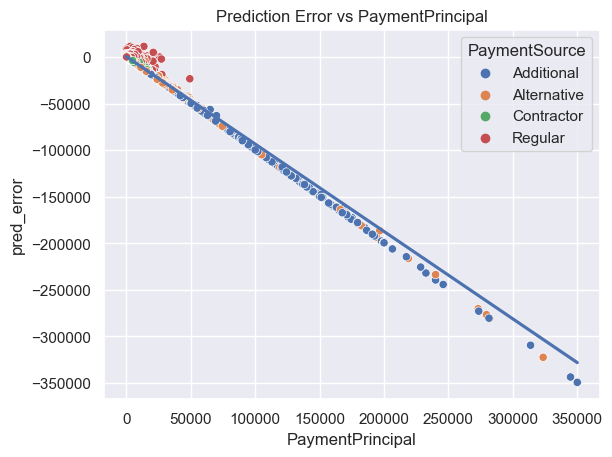

In [60]:
plt.title("Prediction Error vs PaymentPrincipal")
ax = sns.scatterplot(
    data=holdout_df, x="PaymentPrincipal", y="pred_error", hue="PaymentSource",
)
sns.regplot(data=holdout_df, scatter=False, x="PaymentPrincipal", y="pred_error", ax=ax)
plt.show()

Algo que podemos inferir del grafico anterior es que cada `PaymentSource` es una distribucion con distinta varianza en los errores. Al ajustar el modelo a las observaciones (que tienen distinto orden de magnitud promedio, incluso, entre `PaymentSource` distintos), tenemos este gráfico de error donde se ven patrones. Esperariamos que los errores fueran homogeneos o al menos, sin un patron claro.

## Entrenamiento

Hacemos una busqueda de hiperparametros y entrenamos los cuatro modelos. Para cada uno vemos los features mas importantes y los hiperparametro elegidos.

Elegí utilizar `LightGBM` por varios motivos. Primero, frente a otros modelos de boosting de gradiente, como `XGBoost`, me ha resultado siempre mas rapido y liviano en memoria. Es también mucho mas comodo su uso: al no requerir que codifiquemos manualmente las variables categoricas, lo cual hace el pipeline general mucho mas simple.

Recordemos que este es un problema de series de tiempo. Por tanto, no podemos hacer Cross Validation común, dado que estariamos validando sobre datos del pasado entrenando con data del futuro (potencialmente, y casi seguro).

Por  ello, uso [GroupTimeSeriesSplit](http://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/) de [mlxtend](http://rasbt.github.io/mlxtend/). Defino cada `LoanId` como un grupo (ver el uso de [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)) y con la data ordenada por fecha, armo los splits de crossvalidation temporal. La siguiente imagen, de la documentacion de `mlxtend`, ilustra como se ve esto:

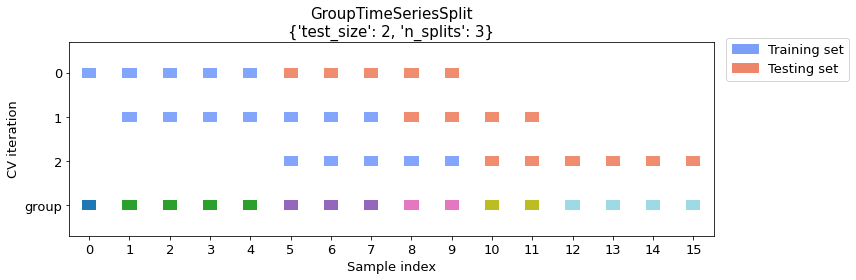

Esos splits luego los uso para hacer grid search, utilizando la implementacion de sklearn. Dado el tamaño del dataset, no es viable (o recomendable) utilizar mas de un job en el mismo. Hacer eso hizo que rompa el kernel, en mi maquina.

In [61]:
models = {}

for payment_source, traindf in [
    ("Additional", train_df_additional),
    ("Alternative", train_df_alternative),
    ("Contractor", train_df_contractor),
    ("Regular", train_df),
]:
    groups = LabelEncoder().fit_transform(traindf.LoanId)

    y = traindf.PaymentPrincipal
    X = traindf[train_columns]

    # TimeSeriesSplit para armar los folds
    cv_args = {"test_size": 100, "n_splits": 3}
    cv = GroupTimeSeriesSplit(**cv_args)
    _ = [_ for _ in cv.split(X, y, groups=groups)]
    cv.get_n_splits()

    reg = LGBMRegressor()

    gscv = GridSearchCV(
        reg,
        param_grid={
            "random_state": [117],
            "boosting_type": ["gbdt"],
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1],
            "metric": ["mae"],
            "force_row_wise": [True],
            "importance_type": ["split"],
            "num_leaves": [31, 63],
        },
        n_jobs=1,
        refit=True,
        cv=cv,
        verbose=2,
        # scoring=amae,
        scoring="neg_mean_absolute_error",
    )
    fit_reg = gscv.fit(X, y, groups=groups)
    models[payment_source] = gscv

    print(gscv.best_score_)

    print(gscv.best_params_)

    print(
        sorted(
            list(
                zip(
                    gscv.best_estimator_.feature_name_,
                    gscv.best_estimator_.feature_importances_,
                )
            ),
            key=lambda x: x[1],
        )
    )

    # Predicciones para el set de holdout
    holdout_df.loc[
        holdout_df.PaymentSource == traindf.PaymentSource.unique()[0], "pred"
    ] = gscv.predict(
        holdout_df.loc[
            holdout_df.PaymentSource == traindf.PaymentSource.unique()[0], train_columns
        ]
    )

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=31, random_state=117; total time=  28.4s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=31, random_state=117; total time=  19.9s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=31, random_state=117; total time=   7.3s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=63, random_state=117; total time=  11.5s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=63, random_state=117; total time=  32.3s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type

In [62]:
feature_imp = []

for payment_source, model in models.items():
    feature_imp.append(
        dict(
            zip(
                model.best_estimator_.feature_name_,
                model.best_estimator_.feature_importances_,
            )
        )
    )

pd.DataFrame(feature_imp)

,PaymentSource,PaymentType,AgencyId,FundingID,LoanAmount,Periodicity,LoanOperationalStatus,VAT,Term,InstallmentAmount,ProductName,Type,D-IndexedTo,PaymentPrincipal_mean,PaymentPrincipal_min,PaymentPrincipal_max,PaymentPrincipal_median
0,0,1006,1360,271,4875,235,67,0,312,4274,0,0,0,0,0,0,0
1,0,0,645,223,1811,70,412,2,56,1466,0,55,5,672,241,340,202
2,0,0,498,275,891,149,157,0,174,975,0,1,0,1003,336,927,614
3,0,0,1834,1137,1328,65,121,13,351,1656,0,105,47,1667,985,1791,1300


In [63]:
MAE(holdout_df.PaymentPrincipal, holdout_df.pred)

279.2528445021317

In [64]:
MAE(holdout_df.PaymentPrincipal, np.abs(holdout_df.pred * (holdout_df.pred >= 0)))

278.6198756385218

In [65]:
holdout_df["abs_err"] = (holdout_df.pred - holdout_df.PaymentPrincipal).abs()
holdout_df.groupby("LoanId").abs_err.mean().mean()

384.9679635322795

Este valor es el error que esperamos frente a nuevos datos. Notemos que es mucho menor que entrenando un solo modelo.

# Hagamos predicciones!

Tenemos dos enfoques posibles, con un tradeoff entre simpleza y correctitud.

### Predecir en batch
Podemos para cada pago tomar las features laggeadas utilizadas desde el ultimo pago conocido en entrenamiento. Esto nos introduce un error conceptual: para cada pago deberiamos considerar las predicciones de pagos anteriores como los pagos y recalcular estas features. Sin embargo perdemos simpleza, legibilidad y estamos, potencialmente, amplificando errores.

### Predecir de a uno
Podriamos predecir cada pago, recalcular features laggeadas y asi hasta haber completado todas las predicciones. Esto involucra mas tiempo de computo y, como dijimos antes, potencialmente estamos acumulando errores de predicciones previas.

En el nombre de la simpleza, iremos con el primer enfoque. Sin embargo, una implentación tentativa del segundo enfoque se deja al final como anexo.

De este modo, la comparacion contra el error del set de holdout es mucho mas directa y valida.

In [66]:
pred = (
    pd.merge(
        predictions_sample, df_orig, left_on="LoanId", right_on="LoanId", how="left"
    )
    .rename(columns={"Date": "PaymentProcessingDate"})
    .sort_values(["PaymentProcessingDate", "LoanId"])
)
pred = pred.merge(df_dindex, left_on="LoanId", right_on="LoanId", how="left")

df.PaymentSource = df.PaymentSource.astype(str)
df.PaymentType = df.PaymentType.astype(float)
df.LoanId = df.LoanId.astype(int)

last_aggs = (
    df.groupby(["LoanId", "PaymentSource", "PaymentType"], dropna=False)
    .PaymentPrincipal.agg(["mean", "min", "max", "median"])
    .add_prefix("PaymentPrincipal_")
    .reset_index(drop=False, level=["LoanId", "PaymentSource", "PaymentType"])
)

wins = (
    df.groupby(["LoanId", "PaymentSource", "PaymentType"], dropna=False)[
        ["WasOnTime", "Lateness", "WasLate", "WasReallyLate", "WasReallyReallyLate"]
    ]
    .agg("mean")
    .add_suffix("_mean")
    .reset_index(drop=False, level=["LoanId", "PaymentSource", "PaymentType"])
)

pred = pred.merge(last_aggs, on=["LoanId", "PaymentSource", "PaymentType"], how="left")

pred = pred.merge(wins, on=["LoanId", "PaymentSource", "PaymentType"], how="left")

In [67]:
categories = [
    "PaymentSource",
    "PaymentType",
    "AgencyId",
    "FundingID",
    "Periodicity",
    "LoanOperationalStatus",
    "VAT",
    "Term",
    "ProductName",
    "Type",
    "D-IndexedTo",
    "LoanId",
]  # "LoanId"]
for category in categories:
    pred[category] = pred[category].astype("category")

In [68]:
pred.PaymentSource.value_counts()

Regular        1714506
Contractor       95290
Alternative      35559
Additional        3034
Name: PaymentSource, dtype: int64

In [69]:
for payment_source, model in models.items():
    print(payment_source, len(pred[pred.PaymentSource == payment_source]))
    pred.loc[pred.PaymentSource == payment_source, "PaymentPrincipal"] = model.predict(
        pred.loc[pred.PaymentSource == payment_source, train_columns]
    )

Additional 3034
Alternative 35559
Contractor 95290
Regular 1714506


In [70]:
pred["PaymentPrincipal"] = (pred.PaymentPrincipal * (pred.PaymentPrincipal >= 0)).abs()

In [71]:
for k, v in cheats.items():
    pred.loc[pred.PaymentCode == k, "PaymentPrincipal"] = v

In [72]:
assert ~pred.PaymentPrincipal.isna().any()

In [73]:
pred[["PaymentCode", "PaymentPrincipal"]].to_csv(
    "lgbm_ijmermet.csv", header=False, index=False
)

In [74]:
!head -n20 lgbm_ijmermet.csv

13200701671045,0.0
08200701671045,8809.984528681895
082007019167594,5537.684073511738
132007019167594,0.0
082007019340648,9573.63449241198
132007019340648,0.0
132007019357922,0.0
082007019357922,14582.183375500459
132007019360821,0.0
082007019360821,23870.385914537186
132007019379876,0.0
082007019379876,10726.353069871036
082007019391054,4208.545808464944
132007019391054,95.15612096514914
132007019402678,302.80905586690506
082007019402678,4339.9084484831765
082007019404027,6395.244267113255
132007019404027,309.2629979325233
132007019406976,297.01708608438497
082007019406976,3431.7579063359403


In [75]:
assert len(pred) == len(predictions_sample)

In [76]:
# Para evitar correr el anexo
raise ValueError()

ValueError: 

# Conclusiones y cierre

El score resultante de este modelo es altamente competitivo, a pesar de que algunos tradeoffs tuvieron que ser tomados en cuenta. Los objetivos planteados inicialmente fueron cumplidos en su totalidad. El framework de tener un modelo baseline y un pipeline que permita comparar rapidamente nuevas variantes de modelos o nuevas features creadas resultó muy cómodo para validar ideas y alternativas que permitieran tener un mejor modelo.

Haber hecho foco en el EDA más temprano en la competencia hubiera permitido probar más variantes con mejores resultados. El _breakthrough_ de entrenar varios modelos llegó tarde durante la competencia.

Sin dudas, queda trabajo por resolver: pulir la predicción fila a fila, probar otros modelos [1], predecir sobre el logaritmo de los valores para reducir la posible heterocedasticidad en los residuos de las predicciones (la variable independiente parecia distribuirse como una lognormal reversa condicionada a `PaymentSource`, según lo visto en el EDA).

[1] - XGBoost en un modo experimental de boosting en GPU ofrece las mismas capacidades que LightGBM de no necesitar transformar a priori las variables categoricas. CatBoost es una alternativa recomendable también.

# Anexo I - Features que no llegaron

## Regresión robusta
Una alternativa a tener un modelo general es tener un modelo por cada prestamo. Pero luego como resolvemos el problema del cold start? Y no podemos aprovechar data entre prestamos, lo cual es suboptimo. Quizas requerimos un modelo para clasificar pagos de `0` vs los que no.

Un modelo sencillo, liviano en computo y robusto a pagos outliers es una regresión por cuadrados minimos con regularización L2. En algun momento, se entrenaba para cada ventana de tiempo de cada prestamo una regresion y sus coeficientes (no sus predicciones) se pasaban como features al modelo de boosting.

En el momento, mejoraba las metricas de holdout, pero quedaron las sospechas sin confirmar de que era solo por errores en el calculo de la metrica en holdout.

Mas allá de si mejoraba o no, era prohibitivemente caro computacionalmente y lento, al tener que repetirse tantas veces (un fit por cada fila!). La complejidad a futuro de predecir/entrenar solo podia empeorar a medida que se registren nuevos pagos.

## Features laggeadas
En la sección de armado de armado de datasets se pueden ver varias features que fueron descartadas por agregar complejidad adicional al modelo sin una ganancia de información evidente en el score de holdout.

# Anexo II - Métrica de evaluación

La competencia indica:
> Sobre todas las predicciones, se reportará el MAE promedio de entre todos los MAE obtenidos para cada crédito.

Lo cual da a entender que se calcula el MAE para cada prestamo y luego se toma el promedio de esos MAEs.

Se ofrece una implementación de un scorer que hace eso, pero no se terminó utilizando para hacer más facil de seguir el codigo, aun asi con buenos resultados y cercanía en los valores de error entre ambos metodos.

In [77]:
class aMAE:
    def __init__(self, full_df):
        self.full_df = full_df

    def __call__(self, est, X, y):
        y_pred = est.predict(X)
        _df = pd.DataFrame({"y": y, "yhat": y_pred,}, index=X.index).join(self.full_df)
        _df["err"] = (_df.y - _df.yhat).abs()
        return -_df.groupby("LoanId").err.agg("mean").mean()


models = {}

for payment_source, traindf in [
    ("Additional", train_df_additional),
    ("Alternative", train_df_alternative),
    ("Contractor", train_df_contractor),
    ("Regular", train_df),
]:
    amae = aMAE(traindf["LoanId"].copy())

    groups = LabelEncoder().fit_transform(traindf.LoanId)

    y = traindf.PaymentPrincipal
    X = traindf[train_columns]

    # TimeSeriesSplit para armar los folds
    cv_args = {"test_size": 100, "n_splits": 3}
    cv = GroupTimeSeriesSplit(**cv_args)
    _ = [_ for _ in cv.split(X, y, groups=groups)]
    cv.get_n_splits()

    reg = LGBMRegressor()

    gscv = GridSearchCV(
        reg,
        param_grid={
            "random_state": [117],
            "boosting_type": ["gbdt"],
            "n_estimators": [100, 200],
            "learning_rate": [0.05, 0.1],
            "metric": ["mae"],
            "force_row_wise": [True],
            "importance_type": ["split"],
            "num_leaves": [31, 63],
        },
        n_jobs=1,
        refit=True,
        cv=cv,
        verbose=2,
        scoring=amae,
        # scoring="neg_mean_absolute_error",
    )
    fit_reg = gscv.fit(X, y, groups=groups)
    models[payment_source] = gscv

    print(gscv.best_score_)

    print(gscv.best_params_)

    print(
        sorted(
            list(
                zip(
                    gscv.best_estimator_.feature_name_,
                    gscv.best_estimator_.feature_importances_,
                )
            ),
            key=lambda x: x[1],
        )
    )

    # Predicciones para el set de holdout
    holdout_df.loc[
        holdout_df.PaymentSource == traindf.PaymentSource.unique()[0], "pred"
    ] = gscv.predict(
        holdout_df.loc[
            holdout_df.PaymentSource == traindf.PaymentSource.unique()[0], train_columns
        ]
    )

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=31, random_state=117; total time=   2.4s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=31, random_state=117; total time=   4.1s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=31, random_state=117; total time=   4.2s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=63, random_state=117; total time=   9.0s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type=split, learning_rate=0.05, metric=mae, n_estimators=100, num_leaves=63, random_state=117; total time=  11.6s
[CV] END boosting_type=gbdt, force_row_wise=True, importance_type

In [78]:
MAE(holdout_df.PaymentPrincipal, holdout_df.pred)

279.2528445021317

In [79]:
MAE(holdout_df.PaymentPrincipal, np.abs(holdout_df.pred * (holdout_df.pred >= 0)))

278.6198756385219

In [80]:
holdout_df["abs_err"] = (holdout_df.pred - holdout_df.PaymentPrincipal).abs()
holdout_df.groupby("LoanId").abs_err.mean().mean()

384.9679635322795

Vemos que el error es... exactamente el mismo que antes! Y perdemos claridad, obligandonos a usar una copia del dataframe para hacer el join.

# Anexo III - Análisis de residuos

Previo a tomar la decision de entrenar cuatro modelos, realice un analisis de residuos sobre las predicciones sobre el dataset de holdout. Esto me llevó al insight que el `PaymentSource` `Alternative` tenía un error mucho mas grande y era el grueso del error reportado.

# Anexo IV - Predecir de a uno

Este codigo no pretende ser funcional, sino servir como base para un trabajo futuro de predecir y evaluar prediciendo de a una fila.

In [ ]:
pred = (
    pd.merge(
        predictions_sample, df_orig, left_on="LoanId", right_on="LoanId", how="left"
    )
    .rename(columns={"Date": "PaymentProcessingDate"})
    .sort_values(["PaymentProcessingDate", "LoanId"])
)
pred = pred.merge(df_dindex, left_on="LoanId", right_on="LoanId", how="left")

df.PaymentSource = df.PaymentSource.astype(str)
df.PaymentType = df.PaymentType.astype(float)
df.LoanId = df.LoanId.astype(int)

categories = [
    "PaymentSource",
    "PaymentType",
    "AgencyId",
    "FundingID",
    "Periodicity",
    "LoanOperationalStatus",
    "VAT",
    "Term",
    "ProductName",
    "Type",
    "D-IndexedTo",
    "LoanId",
]  # "LoanId"]
for category in categories:
    pred[category] = pred[category].astype("category")

In [ ]:
df_copy = (
    df[
        [
            "LoanId",
            "PaymentPrincipal",
            "PaymentProcessingDate",
            "LoanAmount",
            "InstallmentAmount",
            "InstallmentProportion",
        ]
    ]
    .copy()
    .sort_values(by=["PaymentProcessingDate", "LoanId"])
)
pred_copy = pred.sort_values(by=["PaymentProcessingDate", "LoanId"]).copy()

In [ ]:
from IPython.display import display

In [ ]:
predictions = []

while True:
    if len(pred_copy) == 0:
        break

    duped = pred_copy.duplicated(subset=["LoanId"], keep="first")
    pred_iter = pred_copy[~duped]
    pred_copy = pred_copy[duped]

    print(f"Predicting for {len(pred_iter)} rows")

    last_aggs = (
        df_copy.groupby(["LoanId", "PaymentSource", "PaymentType"], dropna=False)
        .PaymentPrincipal.agg(["mean", "min", "max", "median"])
        .add_prefix("PaymentPrincipal_")
        .reset_index(drop=False, level=["LoanId", "PaymentSource", "PaymentType"])
    )

    wins = (
        df_copy.groupby(["LoanId", "PaymentSource", "PaymentType"], dropna=False)[
            ["WasOnTime", "Lateness", "WasLate", "WasReallyLate", "WasReallyReallyLate"]
        ]
        .agg("mean")
        .add_suffix("_mean")
        .reset_index(drop=False, level=["LoanId", "PaymentSource", "PaymentType"])
    )

    pred_iter = pred_iter.merge(
        last_aggs, on=["LoanId", "PaymentSource", "PaymentType"], how="left"
    )

    pred_iter = pred_iter.merge(
        wins, on=["LoanId", "PaymentSource", "PaymentType"], how="left"
    )

    for payment_source, model in models.items():
        print(payment_source, len(pred_iter[pred_iter.PaymentSource == payment_source]))
        pred_iter.loc[
            pred_iter.PaymentSource == payment_source, "PaymentPrincipal"
        ] = model.predict(
            pred_iter.loc[pred_iter.PaymentSource == payment_source, train_columns]
        )

    pred_iter.PaymentPrincipal = (
        pred_iter.PaymentPrincipal * (pred_iter.PaymentPrincipal >= 0)
    ).abs()

    predictions.append(pred_iter[["PaymentCode", "PaymentPrincipal"]])

    df_copy = pd.concat([df_copy, pred_iter[df_copy.columns]]).sort_values(
        by=["PaymentProcessingDate", "LoanId"]
    )

In [ ]:
final_predictions = pd.concat(predictions)

In [ ]:
predictions_sample.pipe(len) - final_predictions.pipe(len)

In [ ]:
final_predictions.PaymentPrincipal = np.abs(
    final_predictions.PaymentPrincipal * (final_predictions.PaymentPrincipal >= 0)
)

In [ ]:
final_predictions.PaymentPrincipal = final_predictions.PaymentPrincipal.round(2)

In [ ]:
final_predictions.PaymentPrincipal = final_predictions.PaymentPrincipal.fillna(0)

In [ ]:
pred_without_history = pred[~pred.LoanId.isin(df_payments.LoanId.unique())]
final_predictions.loc[
    final_predictions.PaymentCode.isin(pred_without_history.PaymentCode.unique()),
    "PaymentPrincipal",
] = 0

pred_without_orig = pred[~pred.LoanId.isin(df_orig.LoanId.unique())]
final_predictions.loc[
    final_predictions.PaymentCode.isin(pred_without_orig.PaymentCode.unique()),
    "PaymentPrincipal",
] = 0

for k, v in cheats.items():
    final_predictions.loc[final_predictions.PaymentCode == k, "PaymentPrincipal"] = v

In [ ]:
final_predictions[["PaymentCode", "PaymentPrincipal"]].to_csv(
    "lgbm_one_at_the_time_ijmermet.csv", header=False, index=False
)

In [ ]:
set(final_predictions.PaymentCode) == set(predictions_sample.PaymentCode)

In [ ]:
final_predictions.head(20)

In [ ]:
!head -n20 lgbm_one_at_the_time_ijmermet.csv